In [1]:
%matplotlib widget
%config InlineBackend.rc = {}


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider
import matplotlib.cm as cm

plt.style.use(['dark_background'])
plt.rcParams.update({'figure.max_open_warning': 0}) 
plt.rcParams['figure.constrained_layout.use'] = True

import warnings
from astropy.utils.exceptions import AstropyWarning, AstropyUserWarning
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter('ignore', category=AstropyUserWarning)
warnings.simplefilter('ignore', UserWarning)

class SpectroDashboard:
    def __init__(self, img=None, cmap="inferno", ref_wavelength=6563):
        self.fig, (self.ax_img, self.ax_spec) = plt.subplots(1, 2, figsize=(12,5))
        self.fig.set_label(' ')
        self.fig.tight_layout()
        self.fig.subplots_adjust(bottom=0.2)

        # États
        self.color_active = False
        self.lines_active = False
        self.velocity_mode = False
        self.lines_artists = []
        self.spectra = []
        self.ref_wavelength = ref_wavelength

        # Image initiale = noire par défaut
        self.img = np.zeros((100,100)) if img is None else np.asarray(img)
        self.cmap = cmap
        self.im = self.ax_img.imshow(self.img, cmap=self.cmap, aspect='equal', origin='upper')
        self.ax_img.axis("off")
        self.cbar = self.fig.colorbar(self.im, ax=self.ax_img, orientation='vertical')
        #self.cbar.ax.tick_params(colors="white")
        #self.cbar.set_label("Intensity", color="white")

        # Spectre initial
        self.ax_spec.set_xlabel("Wavelength [Å]") #, color="white")
        self.ax_spec.set_ylabel("Flux") #, color="white")
        #self.ax_spec.tick_params(colors="white")
        self.ax_spec.grid(True, color="gray", alpha=0.3)

        # --- Contrôles sous l'image ---
        self.ax_slider_max = plt.axes([0.08, 0.08, 0.3, 0.03])
        self.slider_max = Slider(self.ax_slider_max, '', 0, 100, valinit=95, valstep=10 )

        self.ax_slider_min = plt.axes([0.08, 0.02, 0.3, 0.03])
        self.slider_min = Slider(self.ax_slider_min, '', 0, 100, valinit=5, valstep=10 )

        self.slider_min.on_changed(self.update_contrast)
        self.slider_max.on_changed(self.update_contrast)

        # --- Contrôles sous le spectre ---
        self.ax_btn_spec = plt.axes([0.55, 0.05, 0.15, 0.05])
        self.btn_spec = Button(self.ax_btn_spec, 'Clear', color='blue', useblit=True )
        self.btn_spec.on_clicked(self.clear_spec)

        self.ax_btn_color = plt.axes([0.75, 0.05, 0.15, 0.05])
        self.btn_color = Button(self.ax_btn_color, 'Show Color [OFF]', color='blue', useblit=True )
        self.btn_color.on_clicked(self.toggle_color)

        self.ax_btn_lines = plt.axes([0.75, 0.00, 0.15, 0.05])
        self.btn_lines = Button(self.ax_btn_lines, 'Show Lines [OFF]', color='blue', useblit=True )
        self.btn_lines.on_clicked(self.toggle_lines)

        self.ax_btn_vel = plt.axes([0.55, 0.00, 0.15, 0.05])
        self.btn_vel = Button(self.ax_btn_vel, 'Velocity [OFF]', color='blue', useblit=True )
        self.btn_vel.on_clicked(self.toggle_velocity)

        plt.show()

    # --- Méthodes image/spectre ---
    def clear_spec(self, event=None):
        self.ax_spec.clear()
        self.ax_spec.set_facecolor("black")
        # Réinitialiser aussi les overlays couleur si actifs
        for coll in list(self.ax_spec.collections):
            coll.remove()
        self.color_active = False
        self.btn_color.label.set_text("Show Color [OFF]")

        self.ax_spec.set_xlabel("Wavelength [Å]", color="white")
        self.ax_spec.set_ylabel("Flux", color="white")
        self.ax_spec.tick_params(colors="white")
        self.ax_spec.grid(True, color="gray", alpha=0.3)
        # Supprimer les lignes de raies si actives
        for artist in self.lines_artists:
            try:
                artist.remove()
            except Exception:
                pass
        self.lines_artists.clear()
        self.lines_active = False
        self.btn_lines.label.set_text("Show Lines [OFF]")

        self.fig.canvas.draw_idle()

    def update_contrast(self, val=None):
        pmin, pmax = self.slider_min.val, self.slider_max.val
        if pmin >= pmax:
            return
        vmin, vmax = np.percentile(self.img, [pmin, pmax])
        self.im.set_clim(vmin, vmax)
        self.fig.canvas.draw_idle()

    def show_image(self, image_data, header=None, cmap="inferno"):
        self.img = np.asarray(image_data)
        self.cmap = cmap
        if self.cbar is not None:
            try:
                self.cbar.remove()
            except Exception:
                pass
   
        self.ax_img.clear()
        self.im = self.ax_img.imshow(self.img, cmap=self.cmap, aspect='equal', origin='upper')
        self.ax_img.axis("off")
        self.cbar = self.fig.colorbar(self.im, ax=self.ax_img, orientation='vertical')
        self.cbar.ax.tick_params(colors="white")
        #self.cbar.set_label("Intensity", color="white")
        if header is not None:
            obj = header.get("OBJECT", "Image")
            #date = header.get("DATE-OBS", "")
            #self.ax_img.set_title(f"{obj} {date}", fontsize=10, color="white")
            self.ax_img.set_title(f"{obj}", fontsize=10, color="white")
        self.update_contrast()
        self.fig.canvas.draw_idle()

    def show_spectrum(self, wavelength, flux, label=None, **kwargs):
        self.spectra.append((np.array(wavelength), np.array(flux), {"label":label, **kwargs}))
        self._plot_spectra()

    def add_spectrum(self, wavelength, flux, label=None, **kwargs):
        self.show_spectrum(wavelength, flux, label=label, **kwargs)

    def _plot_spectra(self):
        self.ax_spec.clear()
        self.ax_spec.set_facecolor("black")

        for wl, flux, kw in self.spectra:
            if self.velocity_mode:
                v = 299792.458 * (wl - self.ref_wavelength) / self.ref_wavelength
                self.ax_spec.plot(v, flux, **kw)
                self.ax_spec.set_xlabel(
                    f"Velocity [km/s] (ref={self.ref_wavelength} Å)", color="white"
                )
            else:
                self.ax_spec.plot(wl, flux, **kw)
                self.ax_spec.set_xlabel("Wavelength [Å]", color="white")

        self.ax_spec.set_ylabel("Flux", color="white")
        self.ax_spec.tick_params(colors="white")
        self.ax_spec.grid(True, color="gray", alpha=0.3)

        # Légende si labels existent
        handles, labels = self.ax_spec.get_legend_handles_labels()
        if labels:
            leg = self.ax_spec.legend(loc="best", facecolor="black", edgecolor="white")
            for text in leg.get_texts():
                text.set_color("white")

        # Si des lignes de raies sont actives, les réafficher au-dessus
        if self.lines_active:
            self._replot_lines()

        # Si la colorisation était active et qu'on n'est pas en mode vitesse, la réappliquer
        if self.color_active and not self.velocity_mode:
            self.show_color()

        self.fig.canvas.draw_idle()

    # --- Toggle Velocity ---
    def toggle_velocity(self, event=None):
        self.velocity_mode = not self.velocity_mode
        self.btn_vel.label.set_text("Velocity [ON]" if self.velocity_mode else "Velocity [OFF]")
        # En mode vitesse, retirer les zones colorées (non cohérentes)
        if self.velocity_mode and self.color_active:
            for coll in list(self.ax_spec.collections):
                coll.remove()
            self.color_active = False
            self.btn_color.label.set_text("Show Color [OFF]")
        self._plot_spectra()

    def set_reference_wavelength(self, ref_wavelength):
        """Met à jour la longueur d'onde de référence et rafraîchit le tracé."""
        self.ref_wavelength = ref_wavelength
        if self.velocity_mode:
            self._plot_spectra()

    # --- Toggle Lines ---
    def toggle_lines(self, event=None):
        if not self.lines_active:
            # Raies de base
            base_lines = {"H alpha":6563, "H beta":4861, "Na D":5890}
            self.show_lines(base_lines)
            self.lines_active = True
            self.btn_lines.label.set_text("Show Lines [ON]")
        else:
            for artist in self.lines_artists:
                try:
                    artist.remove()
                except Exception:
                    pass
            self.lines_artists.clear()
            self.lines_active = False
            self.btn_lines.label.set_text("Show Lines [OFF]")
        self.fig.canvas.draw_idle()

    def show_lines(self, lines_dict, color="red", linestyle="--"):
        # Tracer dans l'espace courant (wl ou vitesse)
        for name, wavelength in lines_dict.items():
            x = wavelength
            if self.velocity_mode:
                x = 299792.458 * (wavelength - self.ref_wavelength) / self.ref_wavelength
            line = self.ax_spec.axvline(x, color=color, linestyle=linestyle, alpha=0.7)
            y_top = self.ax_spec.get_ylim()[1]
            text = self.ax_spec.text(
                x, y_top*0.95, name, rotation=90, color=color, fontsize=8,
                ha="center", va="top"
            )
            self.lines_artists.extend([line, text])
        self.fig.canvas.draw_idle()

    def _replot_lines(self):
        """Réaffiche les labels des raies après un clear/plot."""
        # On ne connaît pas le dict d'origine ici; on positionne juste les artistes existants en conservant leurs x.
        # Pour une gestion plus avancée, conserver un dict des raies dans self.line_defs.
        # Ici, on ne fait rien: les artists sont recréés par show_lines lors du toggle.
        pass

    # --- Toggle Color ---
    def toggle_color(self, event=None):
        if not self.color_active:
            if self.velocity_mode:
                # On ne colorise pas en mode vitesse (incohérent)
                return
            self.show_color()
            self.color_active = True
            self.btn_color.label.set_text("Show Color [ON]")
        else:
            # Supprimer uniquement les zones colorées (collections)
            for coll in list(self.ax_spec.collections):
                coll.remove()
            self.color_active = False
            self.btn_color.label.set_text("Show Color [OFF]")
        self.fig.canvas.draw_idle()

    def show_color(self):
        # Colorisation en fonction de la longueur d'onde (visible 3800-7500 Å)
        # On parcourt les Line2D tracées; uniquement si en Å
        for line in self.ax_spec.get_lines():
            wl = line.get_xdata()
            flux = line.get_ydata()
            if wl is None or len(wl) < 2:
                continue
            norm = plt.Normalize(vmin=3800, vmax=7500)
            cmap_vis = cm.get_cmap("nipy_spectral")
            # Remplir entre segments adjacents avec couleur selon wl moyenne
            for i in range(len(wl)-1):
                wl_mid = 0.5*(wl[i] + wl[i+1])
                color = cmap_vis(norm(wl_mid))
                self.ax_spec.fill_between(wl[i:i+2], 0, flux[i:i+2], color=color, alpha=0.30)

        self.fig.canvas.draw_idle()


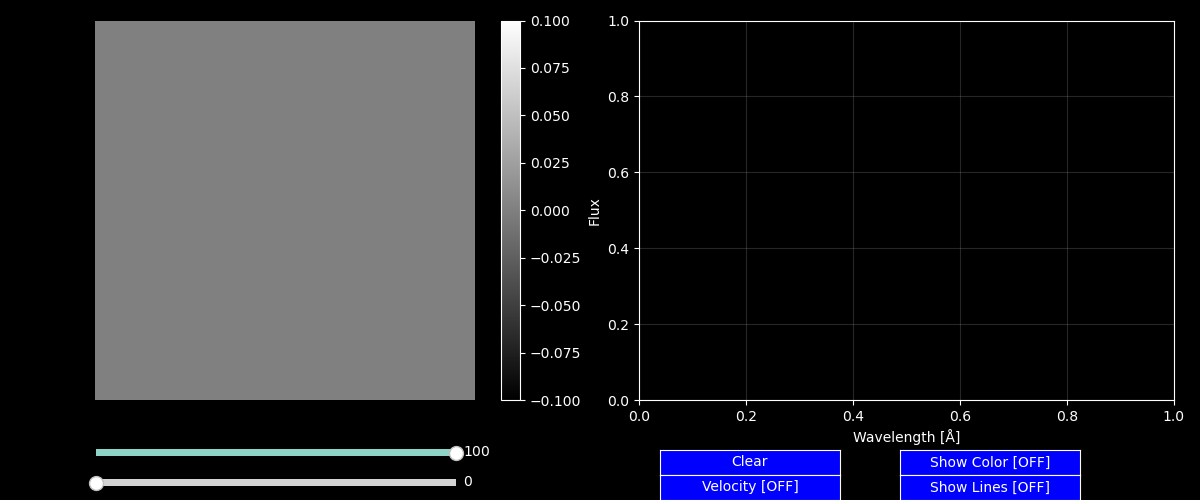

In [7]:
dash = SpectroDashboard(cmap='grey')

# Nouvelle image
img2 = np.random.rand(120,120)
hdr = {"OBJECT":"Vega","DATE-OBS":"2025-11-23"}
dash.show_image(img2, header=hdr)

# Ajouter un spectre en Å
wl = np.linspace(3800,7500,400)
fluxA = np.sin(wl/500)+1
dash.add_spectrum(wl, fluxA, label="Star A", color="blue")


In [12]:
# Ajouter un spectre en Å
wl = np.linspace(3800,7500,400)
fluxA = np.cos(wl/500)+1
dash.add_spectrum(wl, fluxA, label="Star B", color="green")


In [13]:
img3 = np.random.rand(120,120)
hdr = {"OBJECT":"Truc","DATE-OBS":"2025-11-23"}
dash.show_image(img3, header=hdr)


In [9]:
from astropy import units as u
from astropy.nddata import CCDData
import ccdproc as ccdproc

img3 = CCDData.read('../../../CAPTURES/20251102_cxdra_v1770cyg_deneb/_cxdra_20251102_894_2D.fits', unit='adu')
#hdr = {"OBJECT":"Truc","DATE-OBS":"2025-11-23"}
dash.show_image(img3, header=img3.meta)


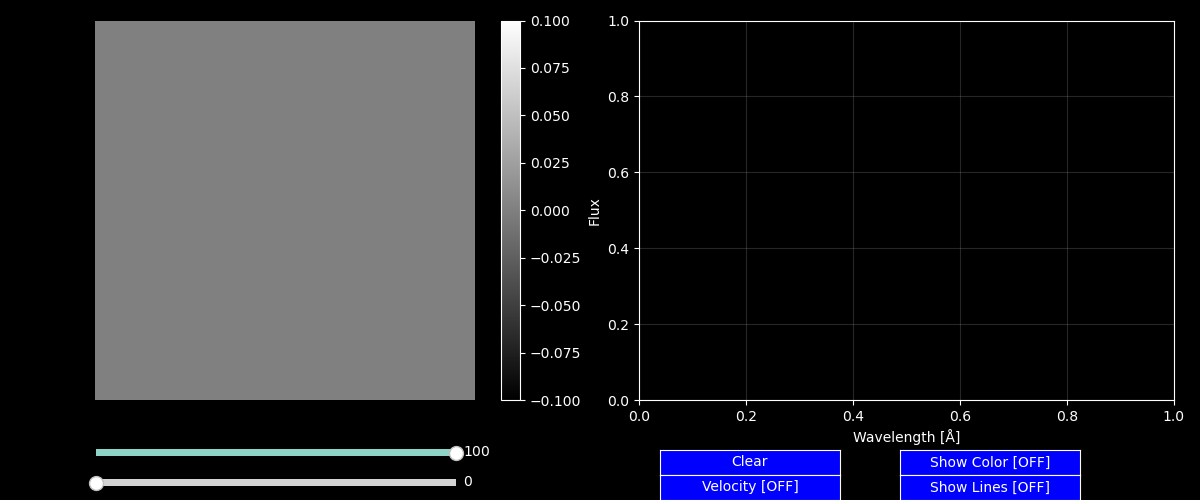

In [8]:
import specutils as spc

dash = SpectroDashboard(cmap='grey')

spc1= spc.Spectrum.read('../../../CAPTURES/20251102_cxdra_v1770cyg_deneb/_cxdra_20251102_894.fits')
#hdr = {"OBJECT":"Truc","DATE-OBS":"2025-11-23"}
dash.show_spectrum(spc1.wavelength, spc1.flux)
